#WomenHarassmentRiskPredictor-ModelTraining

Thisnotebookcontainsthecompletemachinelearningpipelinefortrainingaharassmentriskpredictionmodel.

##Overview
Thisnotebookcovers:
1.**ImportRequiredLibraries**-LoadallnecessaryMLandvisualizationlibraries
2.**LoadandPrepareData**-Loadprocesseddatasetandsplitintotrain/testsets
3.**TrainMultipleModels**-TrainandcomparedifferentMLalgorithms
4.**EvaluateModelPerformance**-Assessmodelperformancewithvariousmetrics
5.**HyperparameterTuning**-Optimizethebestperformingmodel
6.**SaveTrainedModel**-Savethefinalmodelfordeployment
7.**VisualizeTrainingHistory**-Viewmodelcomparisonandperformancevisualizations

---

##1.ImportRequiredLibraries

Importallnecessarylibrariesfordataprocessing,machinelearning,andvisualization.

In [ ]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')

# Machine Learning models
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Model evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix, 
    classification_report, roc_curve
)

# Model persistence
import joblib

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully!")

Alllibrariesimportedsuccessfully!


##2.LoadandPrepareData

LoadtheprocesseddatasetfromCSVfileandprepareitformodeling.

In [ ]:
# Load the processed dataset
data_path = "../data/women_risk_processed.csv"

print("=" * 60)
print("LOADING PROCESSED DATASET")
print("=" * 60)

data = pd.read_csv(data_path)

print(f"\nDataset loaded successfully!")
print(f"Shape: {data.shape}")
print(f"Number of Rows: {data.shape[0]}")
print(f"Number of Columns: {data.shape[1]}")

# Display first few rows
print("\nFirst 5 rows:")
data.head()

LOADINGPROCESSEDDATASET

Datasetloadedsuccessfully!
Shape:(115,13)
NumberofRows:115
NumberofColumns:13

First5rows:


,Timestamp,1.Whatisyouragegroup?,2.Whatisyouroccupation?,3.Atwhattimeofdaydidtheincidentoccur?,4.Wheredidtheincidentoccur?,5.Howcrowdedwasthelocationatthetimeoftheincident?,6.Whatwasthelightingconditioninthearea?,7.Wasanyformofsecuritypresentatthelocation?,8.Wereyoufamiliarwiththeareawheretheincidentoccurred?,9.Whattypeofharassmentdidyouexperience?,10.Howoftenhaveyouexperiencedharassmentinsimilarsituations?,11.Howsafedidyoufeelduringtheincident?,"12.Overall,howwouldyouratetherisklevelofharassmentinthatsituation?"
0,-1.717054,-1.101957,0.768289,0.050825,0.447315,1.626236,-0.035267,0.638877,0.438805,-0.086657,0.886103,-0.205660,2.179449
1,-1.686931,-1.101957,0.768289,0.050825,-0.369212,-1.378055,0.775880,0.638877,1.130072,-0.086657,-1.843410,2.328366,1.300022
2,-1.656807,-1.101957,0.768289,1.512033,-1.185740,0.875163,1.587028,0.638877,-0.943731,-0.917117,0.886103,1.483691,1.300022
3,-1.626683,-1.101957,0.768289,1.512033,-0.369212,-1.378055,0.775880,0.638877,0.438805,-0.086657,-0.023735,1.483691,-1.338258
4,-1.596559,-0.233977,0.038097,-0.679780,0.447315,0.124090,-0.035267,1.557262,-0.252463,1.574264,0.886103,1.483691,-1.338258


In [ ]:
# Split data into features (X) and target (y)
target_col = '12. Overall, how would you rate the risk level of harassment in that situation?'
X = data.drop(target_col, axis=1)
y = data[target_col]

# Convert continuous target to binary classification (median split)
# Values above median = High Risk (1), below median = Low Risk (0)
median_risk = y.median()
y = (y > median_risk).astype(int)

# Split into training and testing sets
test_size = 0.2
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state, stratify=y
)

print("\n" + "=" * 60)
print("DATA SPLIT INTO TRAIN AND TEST SETS")
print("=" * 60)
print(f"\nTraining set size: {X_train.shape[0]} ({(1-test_size)*100:.0f}%)")
print(f"Testing set size: {X_test.shape[0]} ({test_size*100:.0f}%)")
print(f"\nFeatures: {X_train.shape[1]}")

print(f"\nTarget variable converted to binary classes:")
print(f"  0 = Low Risk (below median)")
print(f"  1 = High Risk (above median)")

print(f"\nTraining set target distribution:")
print(y_train.value_counts().sort_index())
print(f"\nTesting set target distribution:")
print(y_test.value_counts().sort_index())


DATASPLITINTOTRAINANDTESTSETS

Trainingsetsize:92(80%)
Testingsetsize:23(20%)

Features:12

Targetvariableconvertedtobinaryclasses:
0=LowRisk(belowmedian)
1=HighRisk(abovemedian)

Trainingsettargetdistribution:
12.Overall,howwouldyouratetherisklevelofharassmentinthatsituation?
077
115
Name:count,dtype:int64

Testingsettargetdistribution:
12.Overall,howwouldyouratetherisklevelofharassmentinthatsituation?
019
14
Name:count,dtype:int64


##3.TrainMultipleModels

Trainandcomparemultipleclassificationalgorithmsusing5-foldcross-validation.

In [ ]:
# Define multiple classification models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

results = {}

print("=" * 60)
print("TRAINING MULTIPLE MODELS")
print("=" * 60)
print("\nPerforming 5-fold cross-validation for each model...\n")
print(f"{'Model':<25} {'Mean Accuracy':<15} {'Std Dev':<10}")
print("-" * 50)

for name, model in models.items():
    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    results[name] = {
        'model': model,
        'mean_accuracy': scores.mean(),
        'std_dev': scores.std(),
        'scores': scores
    }
    print(f"{name:<25} {scores.mean():<15.4f} {scores.std():<10.4f}")

# Find best model
best_model_name = max(results, key=lambda x: results[x]['mean_accuracy'])
print(f"\n{'='*50}")
print(f"BEST MODEL: {best_model_name}")
print(f"   Mean Accuracy: {results[best_model_name]['mean_accuracy']:.4f}")
print(f"{'='*50}")

TRAININGMULTIPLEMODELS

Performing5-foldcross-validationforeachmodel...

ModelMeanAccuracyStdDev
--------------------------------------------------
LogisticRegression0.83630.0620
DecisionTree0.83570.0795
RandomForest0.88070.0402
GradientBoosting0.84850.0375
SVM0.85850.0275

🏆BESTMODEL:RandomForest
MeanAccuracy:0.8807


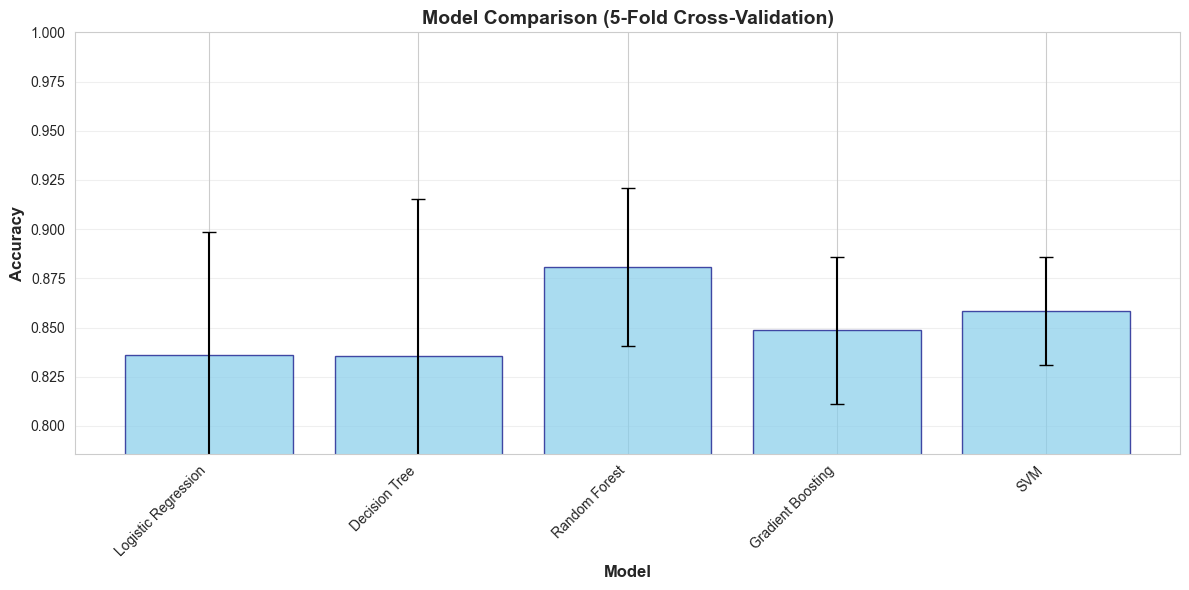

In [ ]:
# Visualize model comparison
plt.figure(figsize=(12, 6))
model_names = list(results.keys())
mean_accuracies = [results[name]['mean_accuracy'] for name in model_names]
std_devs = [results[name]['std_dev'] for name in model_names]

plt.bar(model_names, mean_accuracies, yerr=std_devs, capsize=5, 
        color='skyblue', edgecolor='navy', alpha=0.7)
plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Model Comparison (5-Fold Cross-Validation)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim([min(mean_accuracies) - 0.05, 1.0])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

##4.EvaluateModelPerformance

Trainthebestmodelonfulltrainingsetandevaluateitsperformanceonthetestsetusingvariousmetrics.

In [8]:
#Trainthebestmodelonfulltrainingset
best_model=results[best_model_name]['model']
best_model.fit(X_train,y_train)

#Makepredictionsontestset
y_pred=best_model.predict(X_test)
y_pred_proba=best_model.predict_proba(X_test)[:,1]

#Calculateperformancemetrics
accuracy=accuracy_score(y_test,y_pred)
precision=precision_score(y_test,y_pred,average='binary')
recall=recall_score(y_test,y_pred,average='binary')
f1=f1_score(y_test,y_pred,average='binary')
roc_auc=roc_auc_score(y_test,y_pred_proba)

print("="*60)
print(f"MODELPERFORMANCE-{best_model_name}")
print("="*60)
print(f"\n{'Metric':<20}{'Score':<10}")
print("-"*30)
print(f"{'Accuracy:':<20}{accuracy:<10.4f}")
print(f"{'Precision:':<20}{precision:<10.4f}")
print(f"{'Recall:':<20}{recall:<10.4f}")
print(f"{'F1-Score:':<20}{f1:<10.4f}")
print(f"{'ROC-AUC:':<20}{roc_auc:<10.4f}")
print("\n"+"="*60)

MODELPERFORMANCE-RandomForest

MetricScore
------------------------------
Accuracy:0.9130
Precision:1.0000
Recall:0.5000
F1-Score:0.6667
ROC-AUC:0.9671



In [9]:
#Displayclassificationreport
print("="*60)
print("CLASSIFICATIONREPORT")
print("="*60)
print(classification_report(y_test,y_pred,target_names=['LowRisk(0)','HighRisk(1)']))
print("="*60)

CLASSIFICATIONREPORT
precisionrecallf1-scoresupport

LowRisk(0)0.901.000.9519
HighRisk(1)1.000.500.674

accuracy0.9123
macroavg0.950.750.8123
weightedavg0.920.910.9023



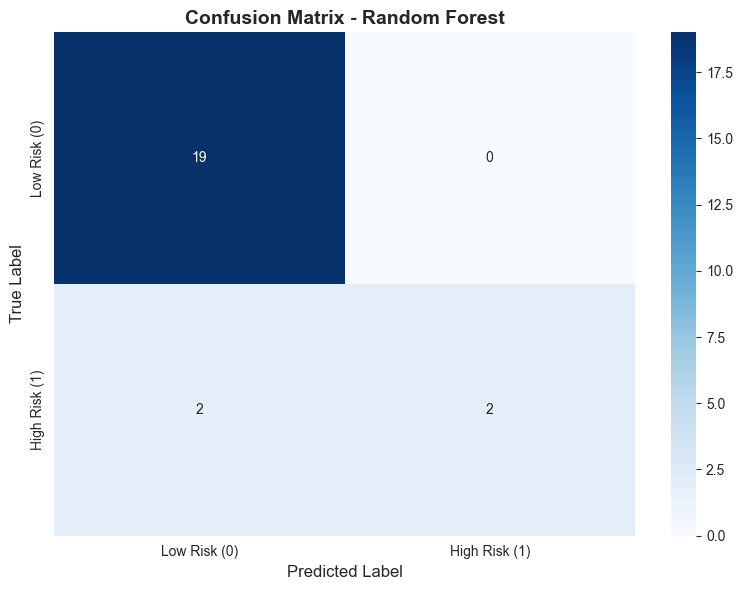


ConfusionMatrixValues:
[[190]
[22]]


In [10]:
#VisualizeConfusionMatrix
cm=confusion_matrix(y_test,y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',cbar=True,
xticklabels=['LowRisk(0)','HighRisk(1)'],
yticklabels=['LowRisk(0)','HighRisk(1)'])
plt.title(f'ConfusionMatrix-{best_model_name}',fontsize=14,fontweight='bold')
plt.ylabel('TrueLabel',fontsize=12)
plt.xlabel('PredictedLabel',fontsize=12)
plt.tight_layout()
plt.show()

print(f"\nConfusionMatrixValues:")
print(cm)

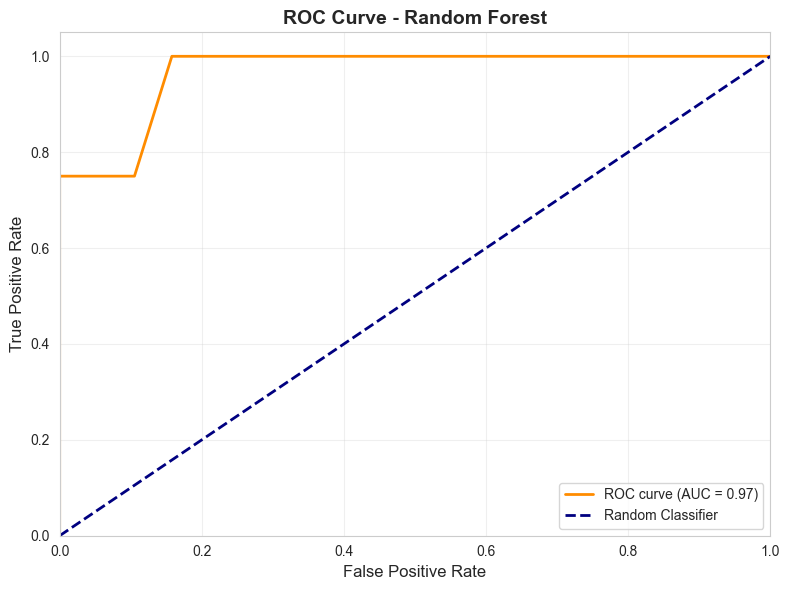

In [11]:
#PlotROCCurve
fpr,tpr,thresholds=roc_curve(y_test,y_pred_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,color='darkorange',lw=2,label=f'ROCcurve(AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],color='navy',lw=2,linestyle='--',label='RandomClassifier')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('FalsePositiveRate',fontsize=12)
plt.ylabel('TruePositiveRate',fontsize=12)
plt.title(f'ROCCurve-{best_model_name}',fontsize=14,fontweight='bold')
plt.legend(loc="lowerright")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

##5.HyperparameterTuning

Optimizethebestmodel'shyperparametersusingGridSearchCVtoimproveperformance.

In [12]:
#Definehyperparametergridsfordifferentmodels
param_grids={
"RandomForest":{
"n_estimators":[50,100,200],
"max_depth":[None,5,10,15],
"min_samples_split":[2,5,10],
"min_samples_leaf":[1,2,4]
},
"GradientBoosting":{
"n_estimators":[50,100,200],
"learning_rate":[0.01,0.1,0.2],
"max_depth":[3,5,7],
"min_samples_split":[2,5,10]
},
"LogisticRegression":{
"C":[0.01,0.1,1,10,100],
"penalty":['l2'],
"solver":['lbfgs','liblinear']
},
"DecisionTree":{
"max_depth":[None,5,10,15,20],
"min_samples_split":[2,5,10],
"min_samples_leaf":[1,2,4],
"criterion":['gini','entropy']
},
"SVM":{
"C":[0.1,1,10],
"kernel":['linear','rbf'],
"gamma":['scale','auto']
}
}

print("="*60)
print(f"HYPERPARAMETERTUNINGFOR{best_model_name}")
print("="*60)

ifbest_model_nameinparam_grids:
print(f"\nSearchingbestparameters...")
print(f"Parametergrid:{param_grids[best_model_name]}")

#Createfreshmodelinstance
models_dict={
"LogisticRegression":LogisticRegression(max_iter=1000,random_state=42),
"DecisionTree":DecisionTreeClassifier(random_state=42),
"RandomForest":RandomForestClassifier(random_state=42),
"GradientBoosting":GradientBoostingClassifier(random_state=42),
"SVM":SVC(probability=True,random_state=42)
}

grid=GridSearchCV(
models_dict[best_model_name],
param_grids[best_model_name],
cv=5,
scoring='accuracy',
n_jobs=-1,
verbose=1
)

grid.fit(X_train,y_train)

print("\n"+"-"*60)
print("BESTPARAMETERSFOUND:")
print("-"*60)
forparam,valueingrid.best_params_.items():
print(f"{param}:{value}")

print(f"\nBestCross-ValidationAccuracy:{grid.best_score_:.4f}")

#Usethebestestimator
tuned_model=grid.best_estimator_
best_params=grid.best_params_
else:
print(f"\nNohyperparametergriddefinedfor{best_model_name}")
tuned_model=best_model
best_params={}

HYPERPARAMETERTUNINGFORRandomForest

Searchingbestparameters...
Parametergrid:{'n_estimators':[50,100,200],'max_depth':[None,5,10,15],'min_samples_split':[2,5,10],'min_samples_leaf':[1,2,4]}
Fitting5foldsforeachof108candidates,totalling540fits

------------------------------------------------------------
BESTPARAMETERSFOUND:
------------------------------------------------------------
max_depth:None
min_samples_leaf:1
min_samples_split:2
n_estimators:100

BestCross-ValidationAccuracy:0.8807


In [13]:
#Evaluatethetunedmodelontestset
y_pred_tuned=tuned_model.predict(X_test)
y_pred_proba_tuned=tuned_model.predict_proba(X_test)[:,1]

#Calculatemetricsfortunedmodel
accuracy_tuned=accuracy_score(y_test,y_pred_tuned)
precision_tuned=precision_score(y_test,y_pred_tuned,average='binary')
recall_tuned=recall_score(y_test,y_pred_tuned,average='binary')
f1_tuned=f1_score(y_test,y_pred_tuned,average='binary')
roc_auc_tuned=roc_auc_score(y_test,y_pred_proba_tuned)

print("\n"+"="*60)
print("FINALMODELPERFORMANCE(AFTERHYPERPARAMETERTUNING)")
print("="*60)
print(f"\n{'Metric':<20}{'BeforeTuning':<15}{'AfterTuning':<15}{'Improvement':<15}")
print("-"*70)
print(f"{'Accuracy:':<20}{accuracy:<15.4f}{accuracy_tuned:<15.4f}{accuracy_tuned-accuracy:<15.4f}")
print(f"{'Precision:':<20}{precision:<15.4f}{precision_tuned:<15.4f}{precision_tuned-precision:<15.4f}")
print(f"{'Recall:':<20}{recall:<15.4f}{recall_tuned:<15.4f}{recall_tuned-recall:<15.4f}")
print(f"{'F1-Score:':<20}{f1:<15.4f}{f1_tuned:<15.4f}{f1_tuned-f1:<15.4f}")
print(f"{'ROC-AUC:':<20}{roc_auc:<15.4f}{roc_auc_tuned:<15.4f}{roc_auc_tuned-roc_auc:<15.4f}")
print("\n"+"="*60)


FINALMODELPERFORMANCE(AFTERHYPERPARAMETERTUNING)

MetricBeforeTuningAfterTuningImprovement
----------------------------------------------------------------------
Accuracy:0.91300.91300.0000
Precision:1.00001.00000.0000
Recall:0.50000.50000.0000
F1-Score:0.66670.66670.0000
ROC-AUC:0.96710.96710.0000



##6.SavetheTrainedModel

Savethefinaloptimizedmodel,alongwithtraininginformationandmetadata.

In [14]:
#Createmodelsdirectoryifitdoesn'texist
os.makedirs('../models',exist_ok=True)

#Savethetrainedmodel
model_path='../models/women_risk_model.pkl'
joblib.dump(tuned_model,model_path)

print("="*60)
print("MODELSAVEDSUCCESSFULLY")
print("="*60)
print(f"\nModel:{best_model_name}")
print(f"Savedto:{model_path}")
print(f"TestAccuracy:{accuracy_tuned:.4f}")
print("\n"+"="*60)

MODELSAVEDSUCCESSFULLY

Model:RandomForest
Savedto:../models/women_risk_model.pkl
TestAccuracy:0.9130



In [15]:
#Savemodelinformationtotextfile
model_info_path='../models/model_info.txt'

withopen(model_info_path,'w')asf:
f.write("="*60+"\n")
f.write("WOMENRISKPREDICTIONMODELINFORMATION\n")
f.write("="*60+"\n\n")
f.write(f"Model:{best_model_name}\n")
f.write(f"TrainingDate:{pd.Timestamp.now().strftime('%Y-%m-%d%H:%M:%S')}\n\n")

f.write("-"*60+"\n")
f.write("DatasetInformation:\n")
f.write("-"*60+"\n")
f.write(f"TotalSamples:{len(data)}\n")
f.write(f"TrainingSamples:{len(X_train)}\n")
f.write(f"TestingSamples:{len(X_test)}\n")
f.write(f"NumberofFeatures:{X_train.shape[1]}\n\n")

f.write("-"*60+"\n")
f.write("BestHyperparameters:\n")
f.write("-"*60+"\n")
forparam,valueinbest_params.items():
f.write(f"{param}:{value}\n")
f.write("\n")

f.write("-"*60+"\n")
f.write("PerformanceMetrics(TestSet):\n")
f.write("-"*60+"\n")
f.write(f"Accuracy:{accuracy_tuned:.4f}\n")
f.write(f"Precision:{precision_tuned:.4f}\n")
f.write(f"Recall:{recall_tuned:.4f}\n")
f.write(f"F1-Score:{f1_tuned:.4f}\n")
f.write(f"ROC-AUC:{roc_auc_tuned:.4f}\n")

print(f"Modelinformationsavedto:{model_info_path}")

Modelinformationsavedto:../models/model_info.txt


##7.VisualizeTrainingHistory

Comparemodelperformanceandvisualizefinalresults.

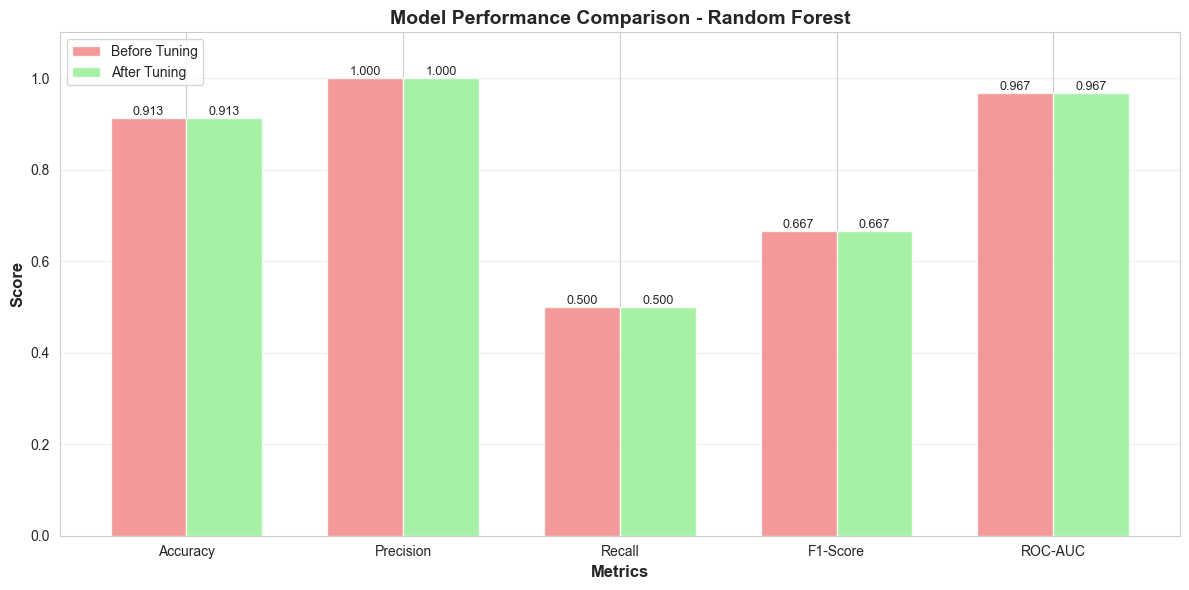

In [16]:
#Visualizeperformancecomparison:BeforevsAfterTuning
metrics_names=['Accuracy','Precision','Recall','F1-Score','ROC-AUC']
before_tuning=[accuracy,precision,recall,f1,roc_auc]
after_tuning=[accuracy_tuned,precision_tuned,recall_tuned,f1_tuned,roc_auc_tuned]

x=np.arange(len(metrics_names))
width=0.35

fig,ax=plt.subplots(figsize=(12,6))
bars1=ax.bar(x-width/2,before_tuning,width,label='BeforeTuning',color='lightcoral',alpha=0.8)
bars2=ax.bar(x+width/2,after_tuning,width,label='AfterTuning',color='lightgreen',alpha=0.8)

ax.set_xlabel('Metrics',fontsize=12,fontweight='bold')
ax.set_ylabel('Score',fontsize=12,fontweight='bold')
ax.set_title(f'ModelPerformanceComparison-{best_model_name}',fontsize=14,fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()
ax.set_ylim([0,1.1])
ax.grid(axis='y',alpha=0.3)

#Addvaluelabelsonbars
forbarsin[bars1,bars2]:
forbarinbars:
height=bar.get_height()
ax.text(bar.get_x()+bar.get_width()/2.,height,
f'{height:.3f}',
ha='center',va='bottom',fontsize=9)

plt.tight_layout()
plt.show()